In [14]:
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image

# **2.1**

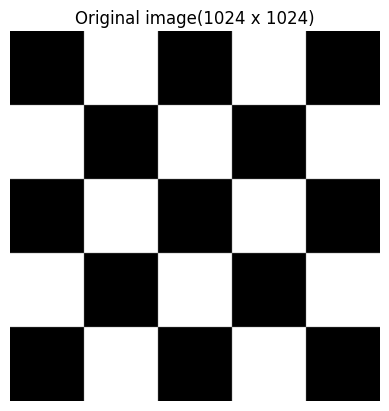

In [ ]:
# Load and process checkerboard img
image_path = 'Checkerboard.png'
img = Image.open(image_path).convert('L')  # Convert to grayscale
img_array = np.array(img)

if img is None:
    print("Error: img not found. Please check the file path.")

# Display the img
plt.imshow(img, cmap='gray')
plt.title("Original image(1024 x 1024)")
plt.axis('off')
plt.show()

# **2.2**

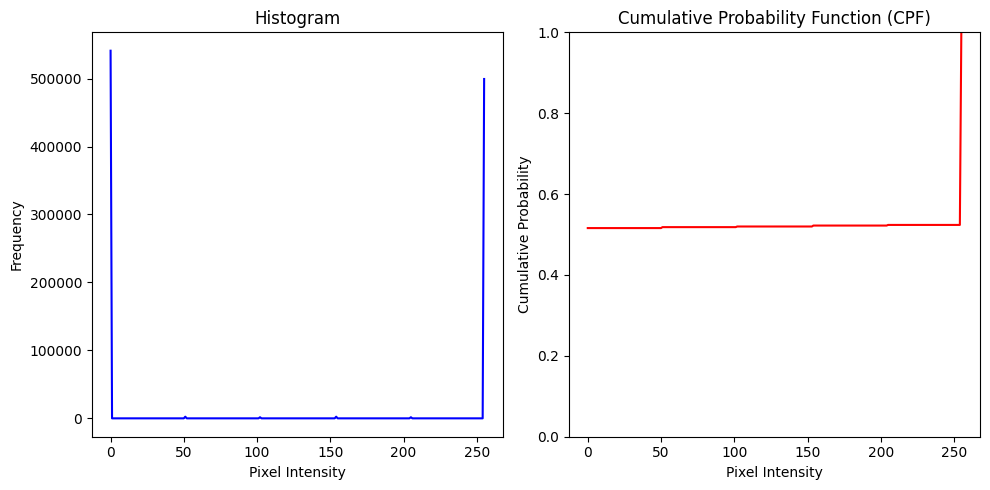

In [ ]:
hist, bins = np.histogram(img_array, bins=256, range=[0,256])
cpf = hist.cumsum()
cpf_normalized = cpf / cpf[-1]  # Normalize to [0,1]

# Plot histogram and CPF
plt.figure(figsize=(10, 5))

# Plot histogram
plt.subplot(1, 2, 1)
plt.plot(hist, color='blue')
plt.title('Histogram')
plt.xlabel('Pixel Intensity')
plt.ylabel('Frequency')

# Plot cumulative probability function (CPF)
plt.subplot(1, 2, 2)
plt.plot(cpf_normalized, color='red')
plt.title('Cumulative Probability Function (CPF)')
plt.xlabel('Pixel Intensity')
plt.ylabel('Cumulative Probability')
plt.ylim(0,1)

plt.tight_layout()
plt.show()

# **2.3**

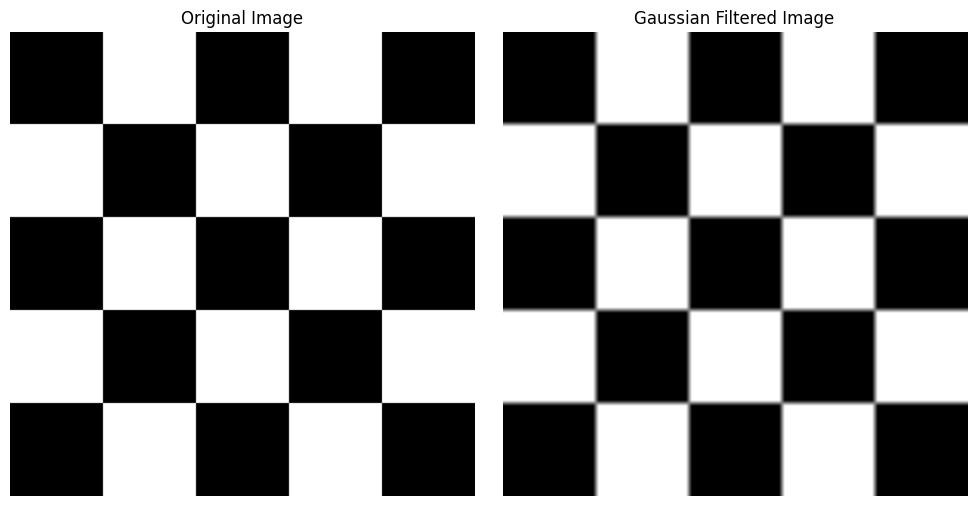

In [ ]:
# Create a Gaussian filter using NumPy
def gaussian_kernel(size, sigma=1):
    ax = np.linspace(-(size // 2), size // 2, size)
    X, Y = np.meshgrid(ax, ax)
    kernel = np.exp(-(X**2 + Y**2) / (2 * sigma**2))
    return kernel / np.sum(kernel)  # Normalize to ensure sum = 1

# Define filter size and standard deviation (sigma)
filter_size = 13  # 13x13 filter
sigma = 7  # Standard deviation for Gaussian
gaussian_kernel = gaussian_kernel(filter_size, sigma)

# Get image dimensions
height, width = img_array.shape

# Create output image
filtered_img = np.zeros_like(img_array, dtype=np.float64)

# Create padded image for edge handling
pad = filter_size // 2
padded_img = np.pad(img_array, ((pad, pad), (pad, pad)), mode='reflect')

# Apply Gaussian filter using manual convolution
for i in range(height):
    for j in range(width):
        # Extract local region
        region = padded_img[i:i+filter_size, j:j+filter_size]
        # Apply Gaussian kernel
        filtered_img[i, j] = np.sum(region * gaussian_kernel)

# Convert back to uint8 (valid image format)
filtered_img = np.clip(filtered_img, 0, 255).astype(np.uint8)

# Display original and filtered images
plt.figure(figsize=(10, 5))
plt.subplot(121)
plt.imshow(img_array, cmap='gray')
plt.title('Original Image')
plt.axis('off')

plt.subplot(122)
plt.imshow(filtered_img, cmap='gray')
plt.title('Gaussian Filtered Image')
plt.axis('off')
plt.tight_layout()
plt.show()

# **2.4**

Yes it is seperable because the equation for the gaussian filter for 2D is given by:
$w(i,j) = Ke^{\frac{x^2+y^2}{2\sigma^2}}$

This can be factored or broken down to be processed in 1D as

$w(i,j) = \sqrt{K}e^{\frac{x^2}{2\sigma^2}}.\sqrt{K}e^{\frac{y^2}{2\sigma^2}}$

Instead of applying a 2D convolution, you can apply two 1D convolutions (one along rows, one along columns), reducing the complexity from $(O(N^2)$ to $O(2N)$.The output remains identical to using the full 2D kernel.

# **2.5**

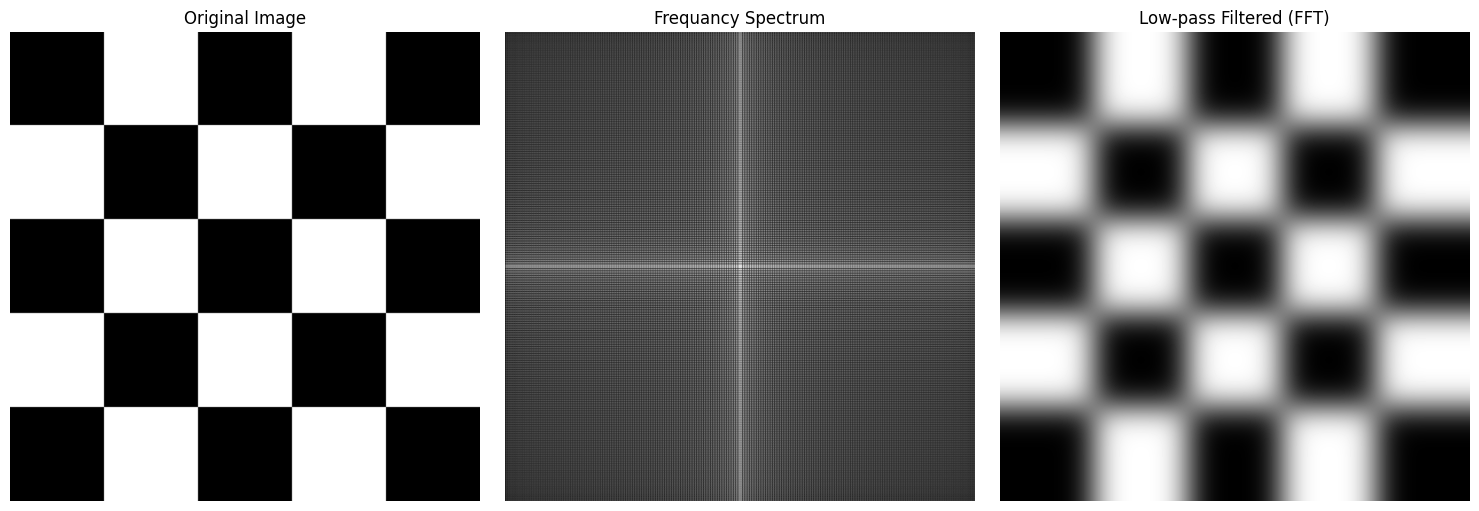

In [18]:
# Compute FFT of the image
fft_img = np.fft.fft2(img_array)
fft_shifted = np.fft.fftshift(fft_img)  # Shift zero frequency to the center

# Compute magnitude spectrum for visualization
frequency_spectrum = np.log1p(np.abs(fft_shifted))  # Log scale for better visibility

# Create a low-pass filter (Gaussian or ideal circle filter)
height, width = img_array.shape
X, Y = np.meshgrid(np.arange(-width//2, width//2), np.arange(-height//2, height//2))
D = np.sqrt(X**2 + Y**2)  # Distance from the center
D0 = 5  # Cutoff frequency (adjustable)
low_pass_filter = np.exp(-(D**2) / (2 * (D0**2)))  # Gaussian low-pass filter

# Apply filter in frequency domain
filtered_fft = fft_shifted * low_pass_filter

# Inverse FFT to get back to spatial domain
ifft_shifted = np.fft.ifftshift(filtered_fft)  # Shift back
filtered_img = np.fft.ifft2(ifft_shifted).real  # Take the real part

# Display images
plt.figure(figsize=(15, 5))

# Original image
plt.subplot(131)
plt.imshow(img_array, cmap='gray')
plt.title('Original Image')
plt.axis('off')

# Frequency domain (magnitude spectrum)
plt.subplot(132)
plt.imshow(frequency_spectrum, cmap='gray')
plt.title('Frequancy Spectrum')
plt.axis('off')

# Low-pass filtered image
plt.subplot(133)
plt.imshow(filtered_img, cmap='gray')
plt.title('Low-pass Filtered (FFT)')
plt.axis('off')

plt.tight_layout()
plt.show()

# **2.6**

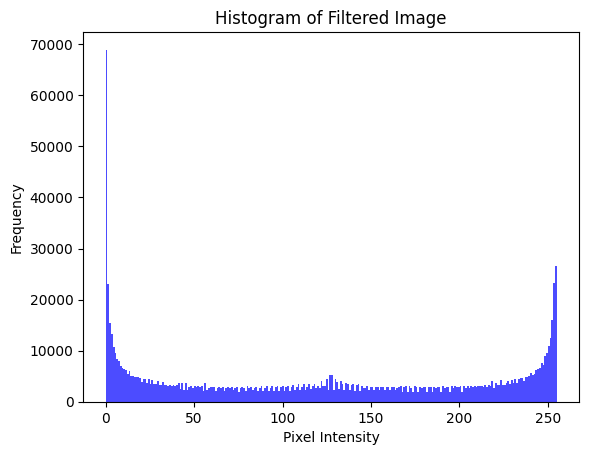

In [19]:
# Compute and plot histogram separately
plt.hist(filtered_img.ravel(), bins=256, range=(0, 255), color='blue', alpha=0.7)
plt.title('Histogram of Filtered Image')
plt.xlabel('Pixel Intensity')
plt.ylabel('Frequency')
plt.show()

# **2.7**

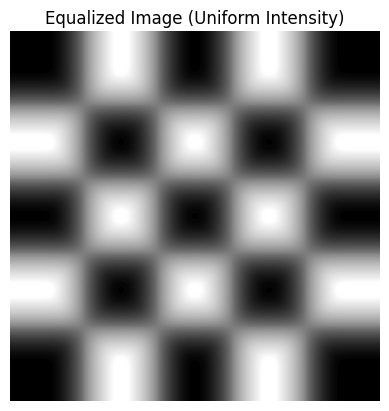

In [20]:
# Load low-pass filtered image (ensure it is in grayscale uint8 format)
filtered_img = np.array(filtered_img, dtype=np.uint8)

# Compute histogram
hist, bins = np.histogram(filtered_img.flatten(), bins=256, range=[0, 255])

# Compute the cumulative distribution function (CDF)
cdf = hist.cumsum()
cdf_normalized = cdf / cdf.max()  # Normalize to range [0,1]

# Map original intensities to equalized values
cdf_min = cdf[cdf > 0].min()  # Minimum nonzero value
cdf_scaled = (cdf - cdf_min) / (cdf.max() - cdf_min) * 255  # Scale to [0, 255]
equalized_img = np.interp(filtered_img.flatten(), bins[:-1], cdf_scaled).reshape(filtered_img.shape)
equalized_img = equalized_img.astype(np.uint8)  # Convert to uint8

# Display the transformed image
plt.imshow(equalized_img, cmap='gray')
plt.title('Equalized Image (Uniform Intensity)')
plt.axis('off')
plt.show()

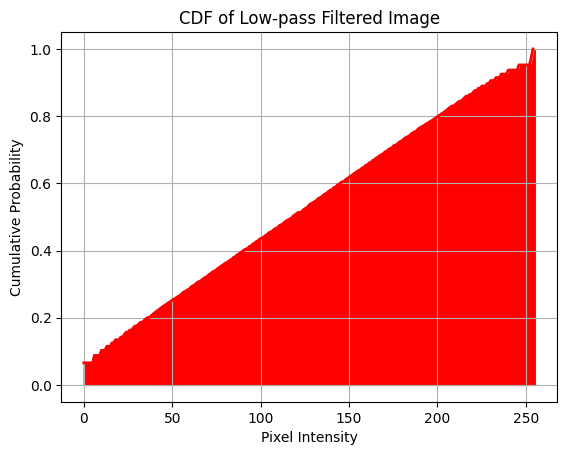

In [ ]:
# Compute histogram
hist, bins = np.histogram(equalized_img.flatten(), bins=256, range=[0, 255])
# Compute the cumulative distribution function (CDF)
cdf = hist.cumsum()
cdf_normalized = cdf / cdf.max()  # Normalize to [0, 1]

# Plot the CDF of the original filtered image
plt.plot(bins[:-1], cdf_normalized, color='red', linewidth=2)
plt.title('CDF of Low-pass Filtered Image')
plt.xlabel('Pixel Intensity')
plt.ylabel('Cumulative Probability')
plt.fill_between(range(len(cdf_normalized)), cdf_normalized, color='red', alpha=1)
plt.grid()
plt.show()